# Code for Batch Trajectory Alignment and Similarity Metrics

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align, full_joint_align,clean_rot_data, segment_by_demo, sum_of_squares
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data

from evo.core.trajectory import PoseTrajectory3D
from nah.trajectory import get_evo_trajectory, evo_align, evo_sync, evaluate_ape, convert_evo_to_np, get_evo_metrics, Alignment

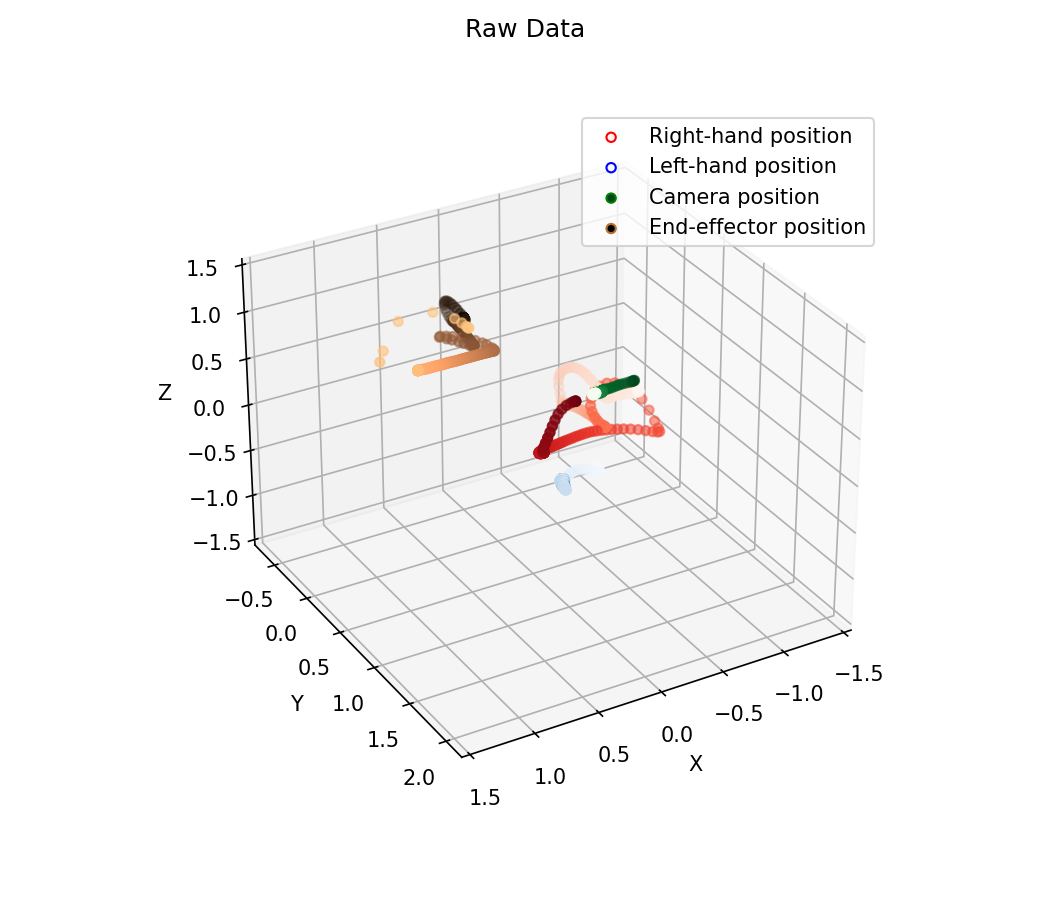

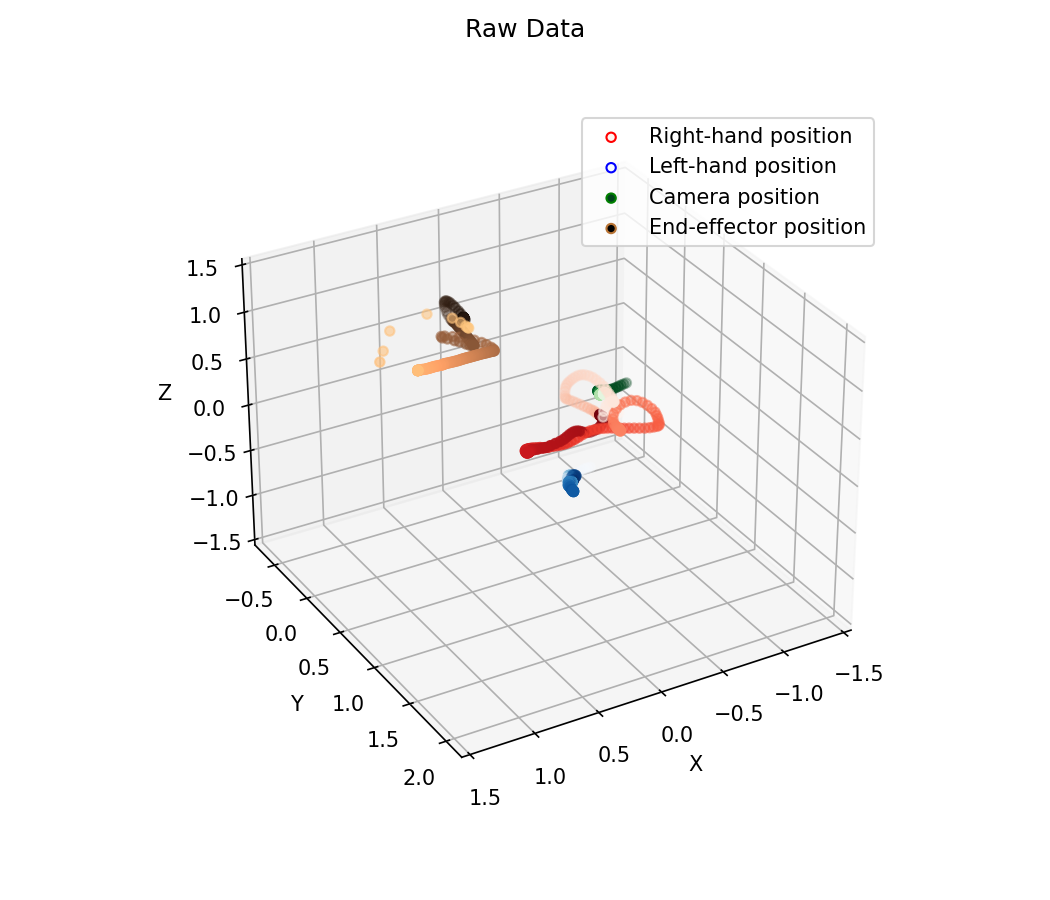

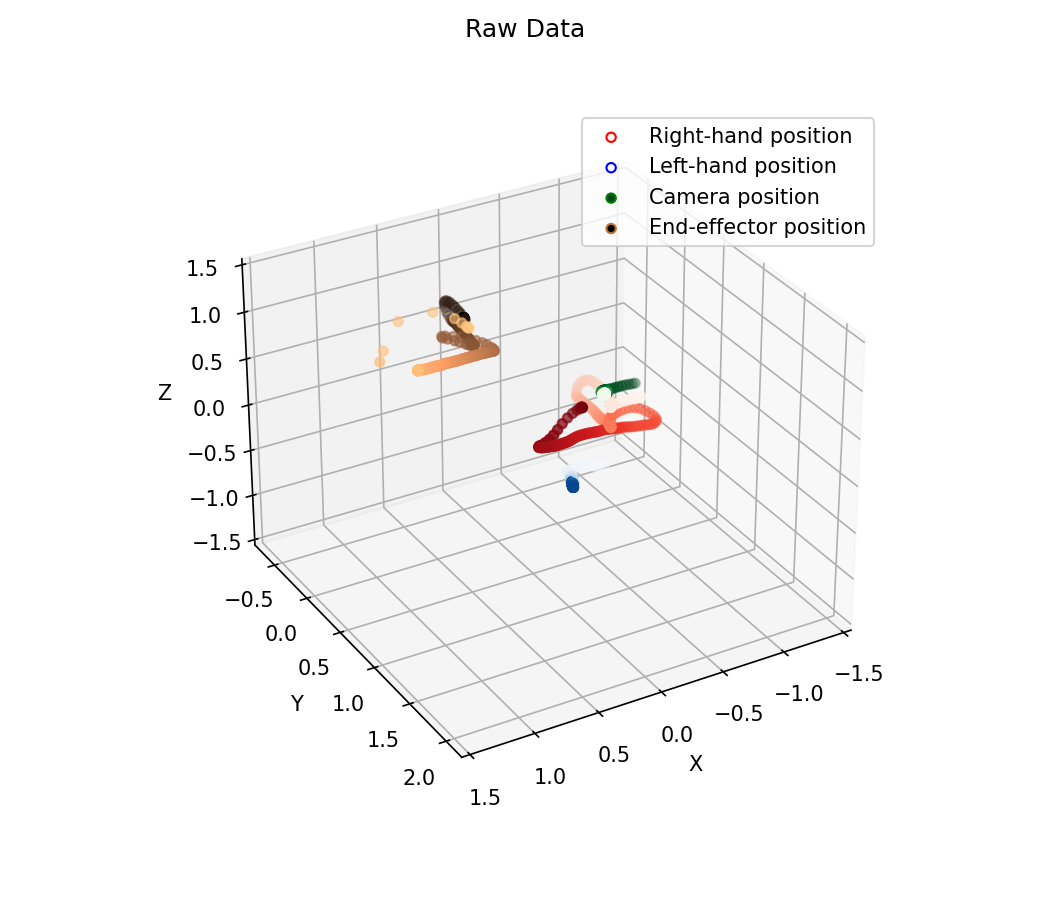

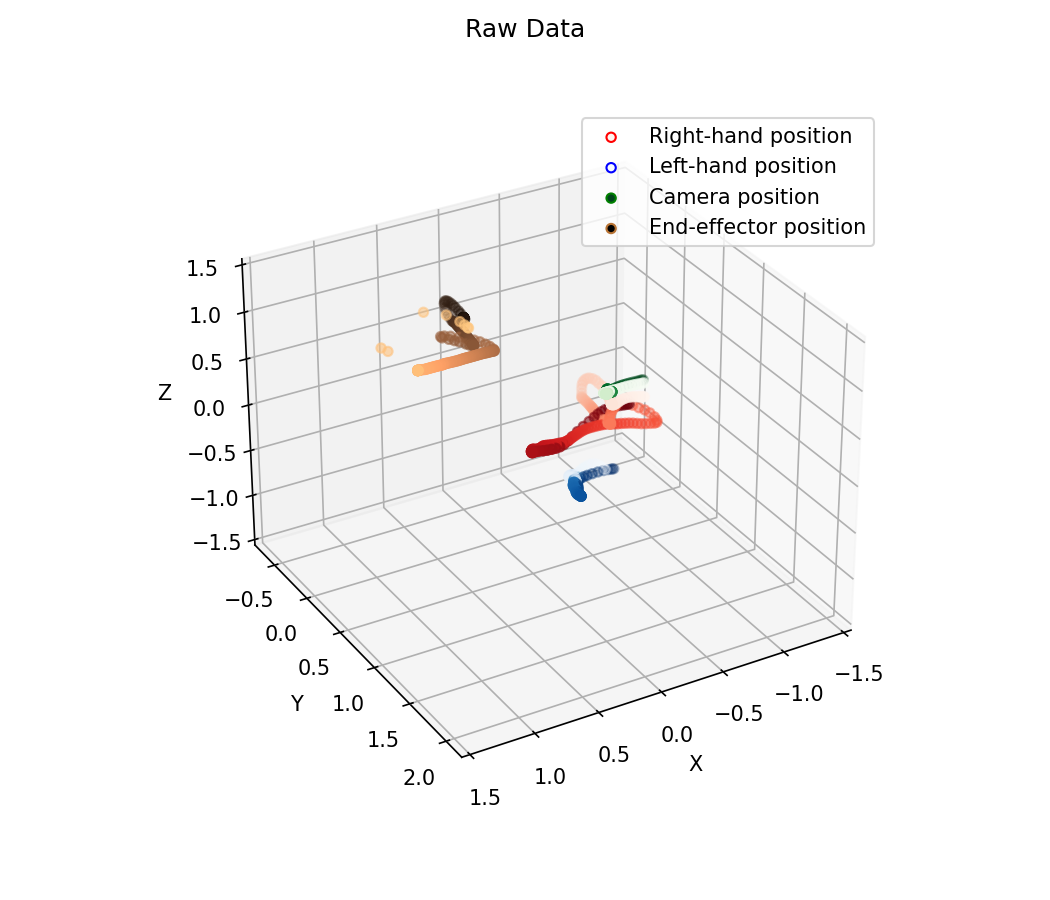

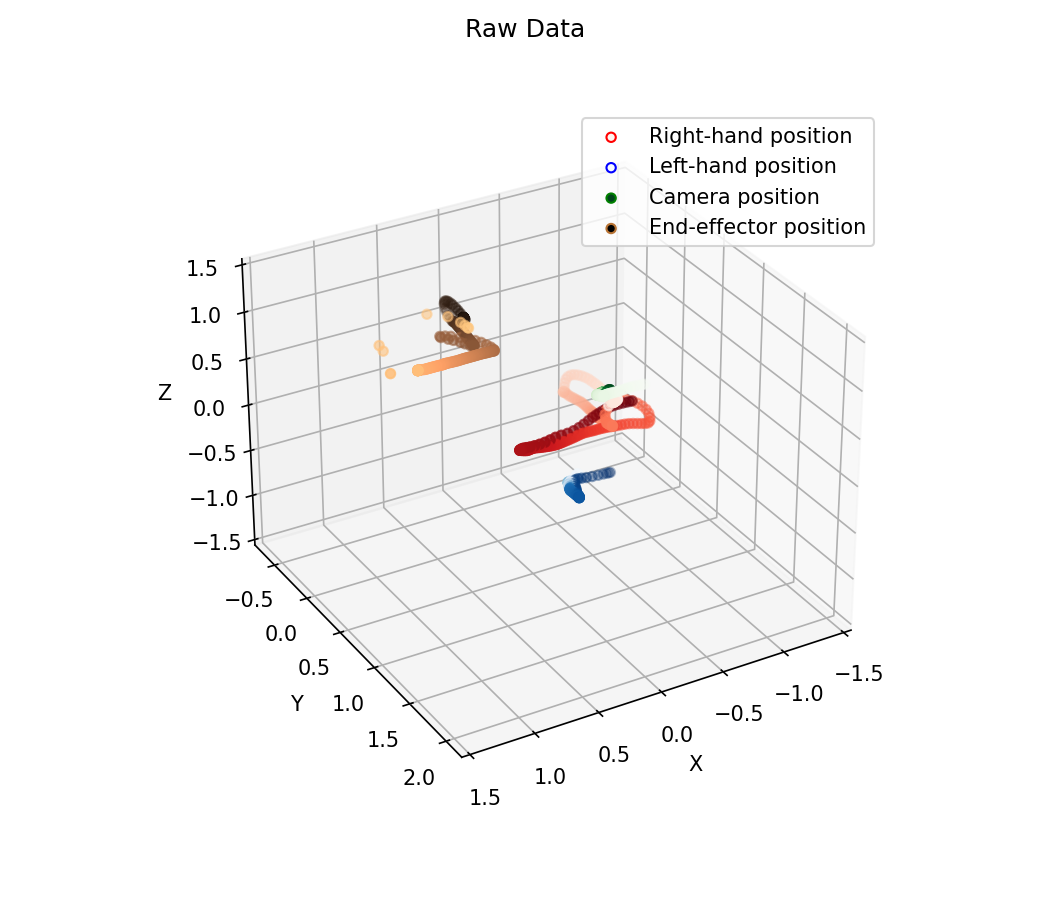

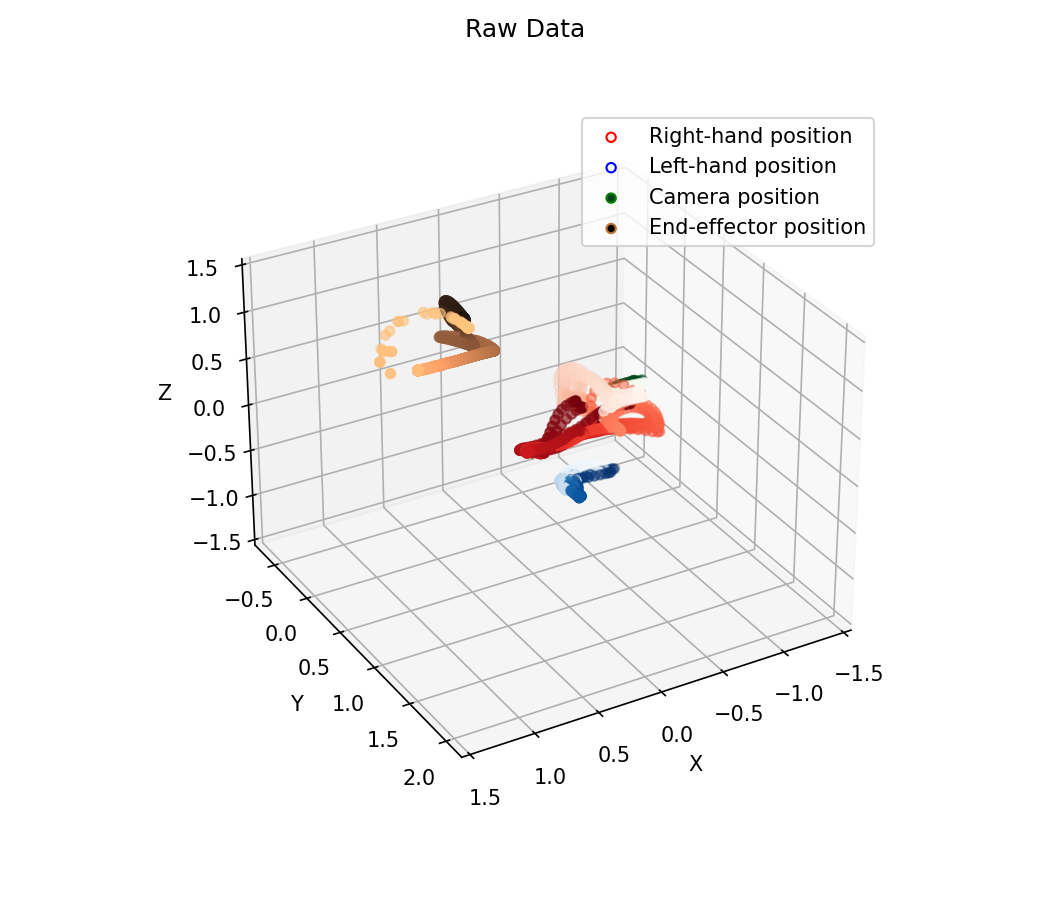

In [3]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

robot_name='j2s6s300'
# robot_name='Reachy'
gesture_num=14


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 4
followup = False

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))

# plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=5
end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(0,5):
    plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

In [4]:
""" Self-similarity heat map:
Note: participant demos do not have to be time or space-aligned before processing.
1) For each robot, go through all participants and gestures and do 
    pairwise comparisons between all 5 participant demos (10 comparisons each)
    (If there are fewer than 5 demos, leave it blank for now. (Assert something
    ludicrious, like infinity or zero.))
2) Average the RMSEs and put into a matrix. Each row is for one participant; 
    each column is for a gesture 
3) Produce a heatmap for the results and title it based off the robot. Clarify
    that this heatmap is for self-similarity of participant demonstrations
"""

def generate_self_similarity_heat_map(robot_name, followup, demo_max):
    if followup:
        PIDmax=10
        gesturemax = 7
    else:
        PIDmax=17
        gesturemax=16

    heatmap_array = np.array([])
    
    for PID in range(1,PIDmax):
        gesture_metrics = np.array([])
        
        for gesture_num in range(1,gesturemax):        
            end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
            try:
                end_eff_multi_demo, camera_multi_demo, rh_multi_demo, lh_multi_demo, joints_multi_demo = \
                segment_by_demo(end_eff, camera, rh, lh, joint, demo_max)
            except: 
                print("PID "+str(PID)+" is missing demos for gesture "+str(gesture_num)+".")                   

            demo_metrics_separate = np.array([])

            # Check for which hand the participant was using:
            #TODO(Jennifer): Figure out whether the LH or RH had a bigger range and assume that was
            # the primary hand that they used. If both hands were used, can we calculate and present
            # both? Not the way the heat map is currently drawn, but at least print out a statement
            # so that I can resolve it with my notes.
            rh_range = np.max(rh[:,1:4],axis=0)[1:4] - np.min(rh[:,1:4],axis=0)[1:4]
            lh_range = np.max(lh[:,1:4],axis=0)[1:4] - np.min(lh[:,1:4],axis=0)[1:4]
            camera_range = np.max(camera[:,1:4],axis=0)[1:4] - np.min(camera[:,1:4],axis=0)[1:4]

            # print("Right hand range:"+ str(np.linalg.norm(rh_range)))
            # print("Left hand range:" + str(np.linalg.norm(lh_range)))
            # print("Camera range:" + str(np.linalg.norm(camera_range)))
            """ TODO(Jennifer): Is it possible to print the heatmap with different colors for different 
                entries, depending on which hand was used? I'd want the luminance to be similar, so that
                a B/W print still makes it easy to see how well things correlate
            """
            if (np.linalg.norm(rh_range)) > (np.linalg.norm(lh_range)):
                hand_data = rh_multi_demo
            else:
                hand_data = lh_multi_demo
            """TODO(Jennifer): Handle it when both rh_range and lh_range are above the threshold that 
                indicates this is a 2-handed motion"""
                
                

            """TODO(Jennifer)
            Check these results: I guess it makes sense that you get a black line for gesture 6, b/c
            it's almost purely rotation and very little movement. Does APE take rotation into account,
            or is this low error simply because the gesture is so short? Is there a way to normalize
            across gestures? (Should we bother?)
            Ans: No need to bother--we'll showcase participant self-similarity anyway, through the 
            cross-correlation matrices.

            Follow-up question: should we align participant gestures in any way? I didn't think we 
            needed to, but Participant 4 wandered all over the room, so at least for them, it might
            be worth it
            """
            for i in range(0,4):                
                for j in range(i+1,5):
                    try:
                        # Centering code, for participants who clearly walked around during or between their demos:
                        camera_shift = np.linalg.norm(camera_multi_demo[i][1:4] - camera_multi_demo[j][1:4])
                        if (np.linalg.norm(camera_range)>0.25 or camera_shift>0.25):
                            print("Centering data for participant "+str(PID)+" gesture "+str(gesture_num))
                            temp_metrics = get_evo_metrics(hand_data[i]-camera_multi_demo[i],hand_data[j]-camera_multi_demo[j])
                        else:
                            # print("Using non-centered data for participant "+str(PID)+" gesture "+str(gesture_num))
                            temp_metrics = get_evo_metrics(hand_data[i],hand_data[j])
                    except:
                        print("Demo "+str(j)+" is missing for PID "+str(PID)+", gesture "+str(gesture_num)+".")
                        # How do we want to compensate for missing data?
                        # temp_metrics['rmse'] = 10 
                        # raise
                    
                    if (i==1 and j==2):
                        demo_metrics_separate = temp_metrics['rmse']
                    else:
                        demo_metrics_separate = np.hstack((demo_metrics_separate,temp_metrics['rmse']))

            total_demo_rmse = np.mean(demo_metrics_separate)
            # print("PID " + str(PID)+" gesture "+str(gesture_num)+ " demo_rmse: " + str(total_demo_rmse))
                    
            if (gesture_num==1):
                gesture_metrics = total_demo_rmse
            else:
                gesture_metrics = np.hstack((gesture_metrics, total_demo_rmse))

        if PID==1:
            heatmap_array = gesture_metrics
        else:
            heatmap_array = np.vstack((heatmap_array, gesture_metrics))

    print(heatmap_array)
    return heatmap_array

Centering data for participant 1 gesture 8
Centering data for participant 1 gesture 8
Centering data for participant 1 gesture 8
Centering data for participant 1 gesture 8
Centering data for participant 1 gesture 12
Centering data for participant 1 gesture 12
Centering data for participant 1 gesture 12
Centering data for participant 1 gesture 12
Centering data for participant 1 gesture 12
Centering data for participant 1 gesture 12
Centering data for participant 2 gesture 14
Centering data for participant 3 gesture 8
Centering data for participant 3 gesture 13
Centering data for participant 3 gesture 13
Centering data for participant 4 gesture 1
Centering data for participant 4 gesture 1
Centering data for participant 4 gesture 2
Centering data for participant 4 gesture 3
Centering data for participant 4 gesture 6
Centering data for participant 4 gesture 6
Centering data for participant 4 gesture 6
Centering data for participant 4 gesture 6
Centering data for participant 4 gesture 7
Ce

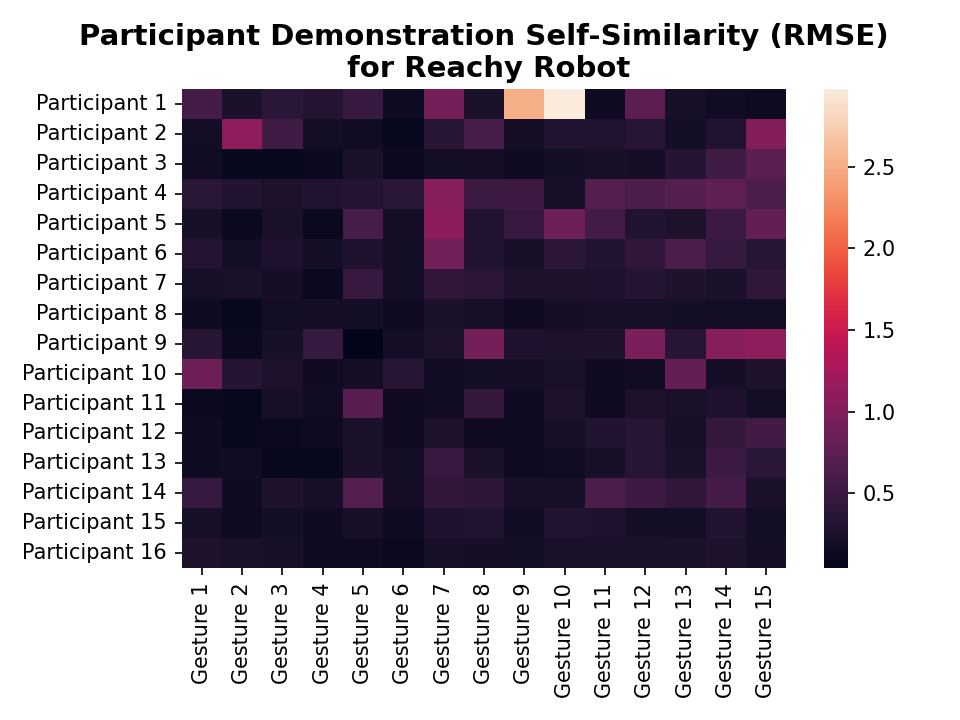

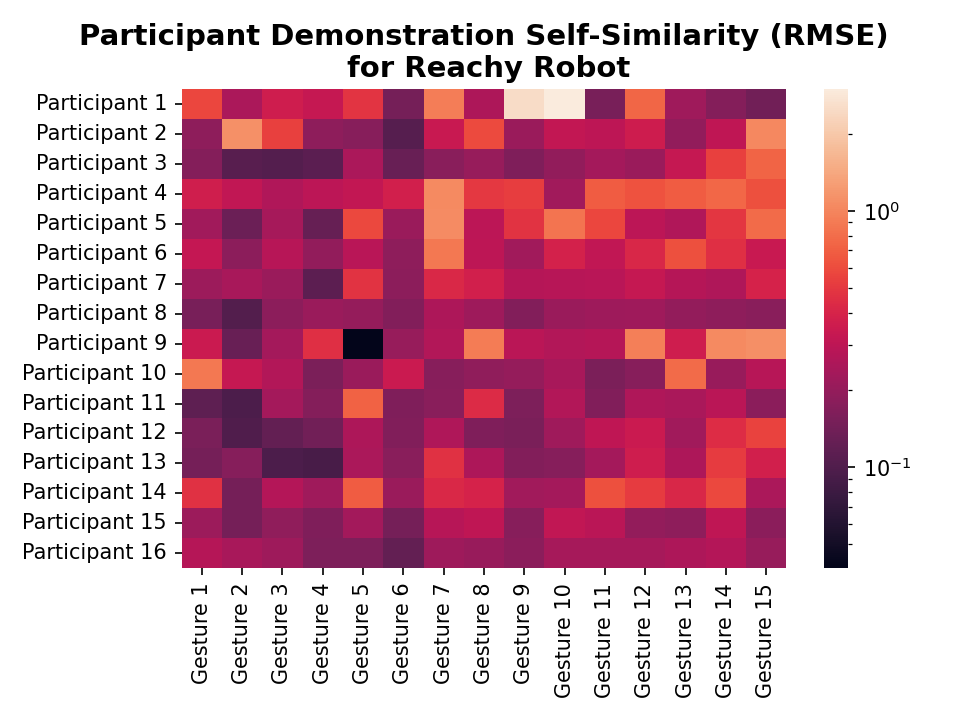

In [15]:
plt.close("all")

# robot_name = "j2s6s300"
robot_name = "Reachy"

followup = False
demo_max = 5

demo_heatmap_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)
participant_labels = []
gesture_labels = []

for i in range(1,17):
    participant_labels.append("Participant "+str(i))
for i in range(1,16):
    gesture_labels.append("Gesture "+str(i))
    
df = pd.DataFrame(demo_heatmap_array, columns = gesture_labels)
df.index = participant_labels

ax = sns.heatmap(df)
ax.set_title("Participant Demonstration Self-Similarity (RMSE)\n for "+robot_name+" Robot",
                 fontsize=14,
                 fontweight="bold")
plt.tight_layout()
plt.show()
plt.savefig('Self_Similarity_'+robot_name+'_v0_LinearPlot_withCentering.png')
plt.close("all")
ax = sns.heatmap(df,norm=LogNorm())
ax.set_title("Participant Demonstration Self-Similarity (RMSE)\n for "+robot_name+" Robot",
                 fontsize=14,
                 fontweight="bold")
plt.tight_layout()
plt.show()
plt.savefig('Self_Similarity_'+robot_name+'_v0_LogPlot_withCentering.png')

Centering data for participant 2 gesture 4
Centering data for participant 2 gesture 4
Centering data for participant 2 gesture 5
Centering data for participant 2 gesture 5
Centering data for participant 2 gesture 5
Centering data for participant 2 gesture 5
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 2
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering data for participant 3 gesture 4
Centering d

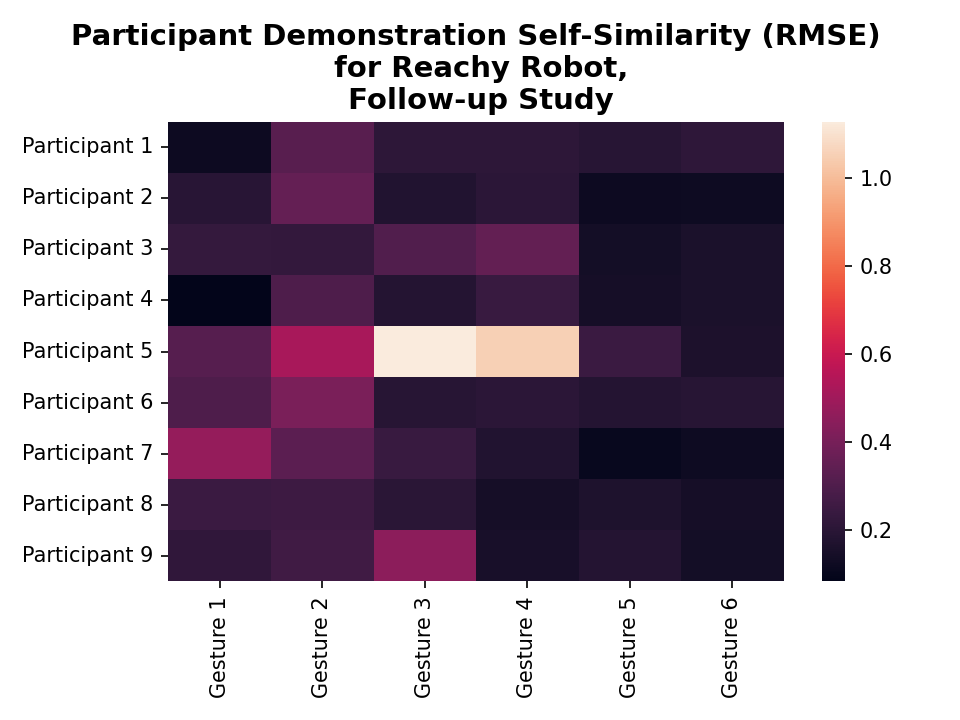

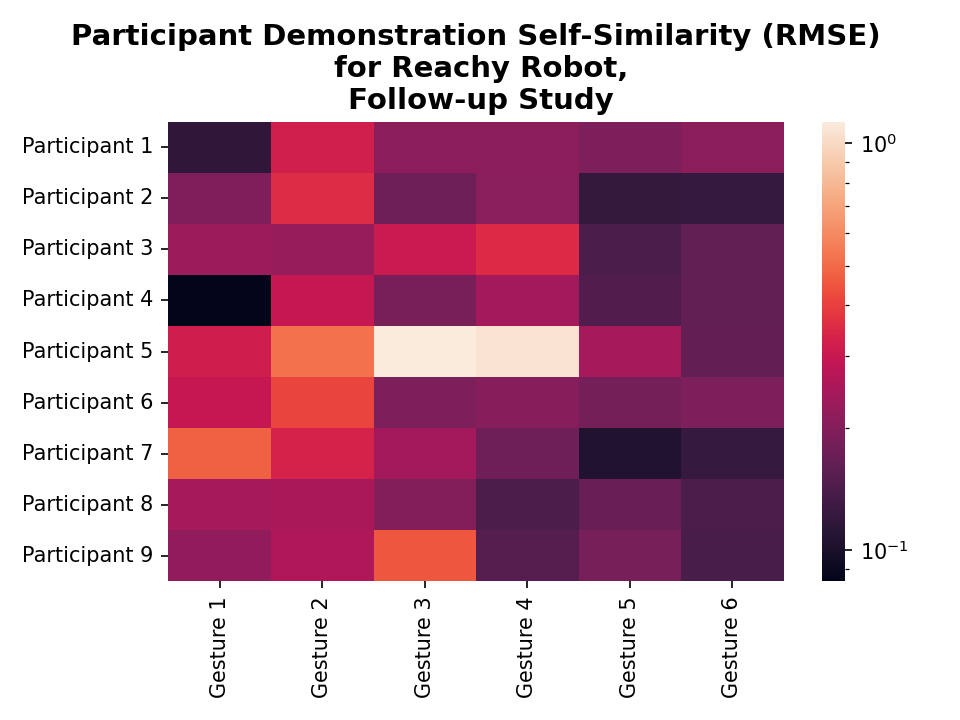

In [16]:
plt.close("all")

# robot_name = "j2s6s300"
robot_name = "Reachy"

followup = True
demo_max = 5

demo_heatmap_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)

participant_labels = []
gesture_labels = []

for i in range(1,10):
    participant_labels.append("Participant "+str(i))
for i in range(1,7):
    gesture_labels.append("Gesture "+str(i))
    
df = pd.DataFrame(demo_heatmap_array, columns = gesture_labels)
df.index = participant_labels

ax = sns.heatmap(df)
ax.set_title("Participant Demonstration Self-Similarity (RMSE)\n for "+robot_name+" Robot,\n Follow-up Study",
                 fontsize=14,
                 fontweight="bold")
plt.tight_layout()
plt.show()
plt.savefig('Self_Similarity_'+robot_name+'_v0_LinearPlot_withCentering_FollowUpStudy.png')
plt.close("all")
ax = sns.heatmap(df,norm=LogNorm())
ax.set_title("Participant Demonstration Self-Similarity (RMSE)\n for "+robot_name+" Robot,\n Follow-up Study",
                 fontsize=14,
                 fontweight="bold")
plt.tight_layout()
plt.show()
plt.savefig('Self_Similarity_'+robot_name+'_v0_LogPlot_withCentering_FollowUpStudy.png')

In [ ]:
warp_path, _, _ = norm_data(sum_of_squares(traj1),sum_of_squares(traj2)) 

In [ ]:
temp = get_evo_metrics(end_eff[2],end_eff[1], alignment=Alignment.Spatial)
# temp = get_evo_metrics(rh[0],rh[1], alignment=Alignment.Spatial)

# TODO: Varun, what is this error?

In [ ]:
end_eff_traj = get_evo_trajectory(end_eff[0])
right_hand_traj = get_evo_trajectory(rh[0])

In [ ]:
end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

metric = evaluate_ape(end_eff_traj, right_hand_traj)
print(metric.get_all_statistics())

right_hand_traj = evo_align(right_hand_traj, end_eff_traj)

In [ ]:
end_eff_aligned = convert_evo_to_np(end_eff_traj)
print(end_eff_aligned.shape)

rh_aligned = convert_evo_to_np(right_hand_traj)
print(rh_aligned.shape)

In [ ]:
# Plot both trajectories on top of each other after alignment:
plot_raw_data(5, end_eff_aligned, camera[0], rh_aligned, lh[0], joint[0])

In [ ]:
metric = evaluate_ape(end_eff_traj, right_hand_traj)
metric.get_all_statistics()

In [ ]:
## Comparison between RH and robot end-eff
# (We'll want comparisons between the person's different demos, and the end-eff and the lh, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15

for singlePIDval in range(1,PID_max+1):
    for gesture_num in range(1,gesture_max+1):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        demo_max=5
        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        for demo_num in range(0,5):
            end_eff_traj = get_evo_trajectory(end_eff[i])
            right_hand_traj = get_evo_trajectory(rh[i])   

            end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            print(metric.get_all_statistics()) # Not aligned statistics
            
            right_hand_traj = align(right_hand_traj, end_eff_traj)

            end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[i].shape)
            # print(end_eff_aligned.shape)
            
            rh_aligned = convert_evo_to_np(right_hand_traj, rh[i].shape)
            # print(rh_aligned.shape)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            metric.get_all_statistics() #Aligned statistics

In [ ]:
## Comparison between RH demos
# (We'll want comparisons between the person's different demos (both RH and LH, depending), and the end-eff and the hands, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False
demo_max = 5

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15


for singlePIDval in range(1,PID_max+1):
# for singlePIDval in range(1,2):    
    for gesture_num in range(1,gesture_max+1):
    # for gesture_num in range(1,2):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        demo_similarity = np.zeros([4,4,3])

        print("PID "+str(singlePIDval)+", gesture "+str(gesture_num))
        for demo_num1 in range(0,demo_max-1):
            for demo_num2 in range(demo_num1+1,demo_max):
                # print("PID "+str(singlePIDval)+", gesture "+str(gesture_num)+", demos "+str(demo_num1)+","+str(demo_num2))
                metrics1 = get_evo_metrics(rh[demo_num1],rh[demo_num2])
                # metrics2 = get_evo_metrics(rh[demo_num1],rh[demo_num2], alignment=Alignment.Spatial)
                # print(metrics1)
                # print(metrics1,metrics2)

                demo_similarity[demo_num1][demo_num2-1][0] = metrics1['rmse']
                demo_similarity[demo_num1][demo_num2-1][1] = metrics1['mean']
                demo_similarity[demo_num1][demo_num2-1][2] = metrics1['std']

        print(demo_similarity)

In [ ]:
metrics1['rmse']

In [ ]:
demo_similarity